# ⚛️ H₂ Ground-State VQE — Noisy Ansatz Convergence (Pure Package Client)

This notebook compares **VQE convergence under noise** for multiple ansätze using only:

```python
from vqe.core import run_vqe
```

Workflow:
1) Run noisy VQE for each ansatz (single seed) and collect energy traces
2) Identify the *worst* ansatz (highest final energy)
3) Re-run the worst case and inspect dominant populations from diag(ρ)

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from vqe.core import run_vqe

## Configuration

In [13]:
molecule = "H2"
seed = 0

optimizer_name = "Adam"
steps = 75
stepsize = 0.2
mapping = "jordan_wigner"

# Noise settings (intentionally exaggerated for visibility)
depolarizing_prob = 0.05
amplitude_damping_prob = 0.05

ansatzes = [
    "UCC-S",
    "UCC-D",
    "UCCSD",
    "Minimal",
    "RY-CZ",
    "TwoQubit-RY-CNOT",
    "StronglyEntanglingLayers",
]

print("Molecule:", molecule)
print("Seed:", seed)
print("Optimizer:", optimizer_name)
print("Steps/stepsize:", steps, stepsize)
print("Mapping:", mapping)
print("Noise: dep=", depolarizing_prob, " amp=", amplitude_damping_prob)
print("Ansatzes:", ansatzes)

Molecule: H2
Seed: 0
Optimizer: Adam
Steps/stepsize: 75 0.2
Mapping: jordan_wigner
Noise: dep= 0.05  amp= 0.05
Ansatzes: ['UCC-S', 'UCC-D', 'UCCSD', 'Minimal', 'RY-CZ', 'TwoQubit-RY-CNOT', 'StronglyEntanglingLayers']


## Part 1 — Run noisy VQE for each ansatz (collect convergence)

In [14]:
traces = {}
final_energies = {}

for a in ansatzes:
    r = run_vqe(
        molecule=molecule,
        ansatz_name=a,
        optimizer_name=optimizer_name,
        steps=int(steps),
        stepsize=float(stepsize),
        noisy=True,
        depolarizing_prob=float(depolarizing_prob),
        amplitude_damping_prob=float(amplitude_damping_prob),
        mapping=mapping,
        seed=int(seed),
        plot=False,
        force=False,
    )

    E_trace = [float(x) for x in r.get("energies", [])]
    if len(E_trace) == 0:
        raise RuntimeError(f"run_vqe returned no energies trace for ansatz='{a}'")

    traces[a] = E_trace
    final_energies[a] = float(E_trace[-1])

Step 01/75: E = -0.980595 Ha
Step 02/75: E = -0.980313 Ha
Step 03/75: E = -0.975687 Ha
Step 04/75: E = -0.980414 Ha
Step 05/75: E = -0.978587 Ha
Step 06/75: E = -0.977719 Ha
Step 07/75: E = -0.979812 Ha
Step 08/75: E = -0.980504 Ha
Step 09/75: E = -0.979225 Ha
Step 10/75: E = -0.978895 Ha
Step 11/75: E = -0.979950 Ha
Step 12/75: E = -0.980578 Ha
Step 13/75: E = -0.980043 Ha
Step 14/75: E = -0.979519 Ha
Step 15/75: E = -0.979878 Ha
Step 16/75: E = -0.980477 Ha
Step 17/75: E = -0.980470 Ha
Step 18/75: E = -0.980054 Ha
Step 19/75: E = -0.979982 Ha
Step 20/75: E = -0.980334 Ha
Step 21/75: E = -0.980557 Ha
Step 22/75: E = -0.980394 Ha
Step 23/75: E = -0.980203 Ha
Step 24/75: E = -0.980306 Ha
Step 25/75: E = -0.980517 Ha
Step 26/75: E = -0.980528 Ha
Step 27/75: E = -0.980391 Ha
Step 28/75: E = -0.980369 Ha
Step 29/75: E = -0.980490 Ha
Step 30/75: E = -0.980556 Ha
Step 31/75: E = -0.980496 Ha
Step 32/75: E = -0.980449 Ha
Step 33/75: E = -0.980499 Ha
Step 34/75: E = -0.980557 Ha
Step 35/75: E 

## Part 2 — Plot convergence curves

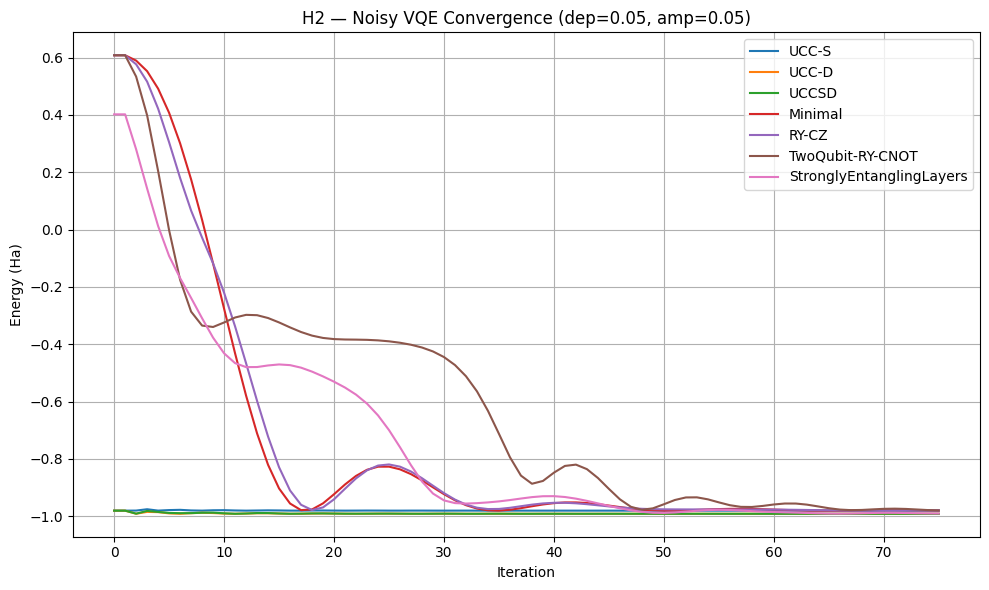

In [15]:
plt.figure(figsize=(10, 6))
for a in ansatzes:
    plt.plot(traces[a], label=a)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title(
    f"{molecule} — Noisy VQE Convergence (dep={depolarizing_prob}, amp={amplitude_damping_prob})"
)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 3 — Identify the worst ansatz (highest final energy)

In [16]:
worst_ansatz = max(final_energies, key=final_energies.get)
print("Final energies (Ha):")
for a in ansatzes:
    print(f"  {a:>24s} : {final_energies[a]: .10f}")

print(f"\nWorst ansatz under noise: {worst_ansatz}")

Final energies (Ha):
                     UCC-S : -0.9805927310
                     UCC-D : -0.9915446482
                     UCCSD : -0.9915442393
                   Minimal : -0.9800870114
                     RY-CZ : -0.9795435902
          TwoQubit-RY-CNOT : -0.9797731102
  StronglyEntanglingLayers : -0.9904918818

Worst ansatz under noise: RY-CZ


## Part 4 — Re-run worst case and extract density matrix ρ

Engines sometimes return the final mixed state under different keys across refactors.
We extract robustly:
- Prefer `final_rho_real`/`final_rho_imag` if present
- Else fall back to `final_state_real`/`final_state_imag`

Then we reshape to an `(N, N)` matrix if needed.

In [17]:
res = run_vqe(
    molecule=molecule,
    ansatz_name=worst_ansatz,
    optimizer_name=optimizer_name,
    steps=int(steps),
    stepsize=float(stepsize),
    noisy=True,
    depolarizing_prob=float(depolarizing_prob),
    amplitude_damping_prob=float(amplitude_damping_prob),
    mapping=mapping,
    seed=int(seed),
    plot=False,
    force=False,
)

rho_r = None
rho_i = None

if "final_rho_real" in res and "final_rho_imag" in res:
    rho_r = np.array(res["final_rho_real"], dtype=float)
    rho_i = np.array(res["final_rho_imag"], dtype=float)
elif "final_state_real" in res and "final_state_imag" in res:
    rho_r = np.array(res["final_state_real"], dtype=float)
    rho_i = np.array(res["final_state_imag"], dtype=float)
else:
    raise KeyError(
        "Expected final density/state arrays in result. "
        "Looked for (final_rho_real/final_rho_imag) or (final_state_real/final_state_imag)."
    )

rho = rho_r + 1j * rho_i

# If returned flattened, reshape to square
if rho.ndim == 1:
    n = int(np.sqrt(rho.size))
    if n * n != rho.size:
        raise ValueError(f"Cannot reshape size={rho.size} to a square density matrix.")
    rho = rho.reshape((n, n))

if rho.shape[0] != rho.shape[1]:
    raise ValueError(f"Expected square density matrix; got shape={rho.shape}.")

num_wires = int(np.log2(rho.shape[0]))
print("ρ shape:", rho.shape, " -> wires:", num_wires)

ρ shape: (16, 16)  -> wires: 4


## Part 5 — Dominant basis-state populations from diag(ρ)

In [18]:
diag = np.real(np.diag(rho))
diag = np.clip(diag, 0.0, None)

threshold = 1e-2
idx = np.where(diag > threshold)[0]

terms = [f"({diag[i]:.4f}|{i:0{num_wires}b}⟩)" for i in idx]
print(f"\nSignificant populations (diag(ρ) > {threshold:g}):")
print("  " + (" + ".join(terms) if terms else "(none above threshold)"))


Significant populations (diag(ρ) > 0.01):
  (0.0706|0100⟩) + (0.0706|1000⟩) + (0.7896|1100⟩) + (0.0261|1101⟩) + (0.0261|1110⟩)


## Part 6 — Plot populations

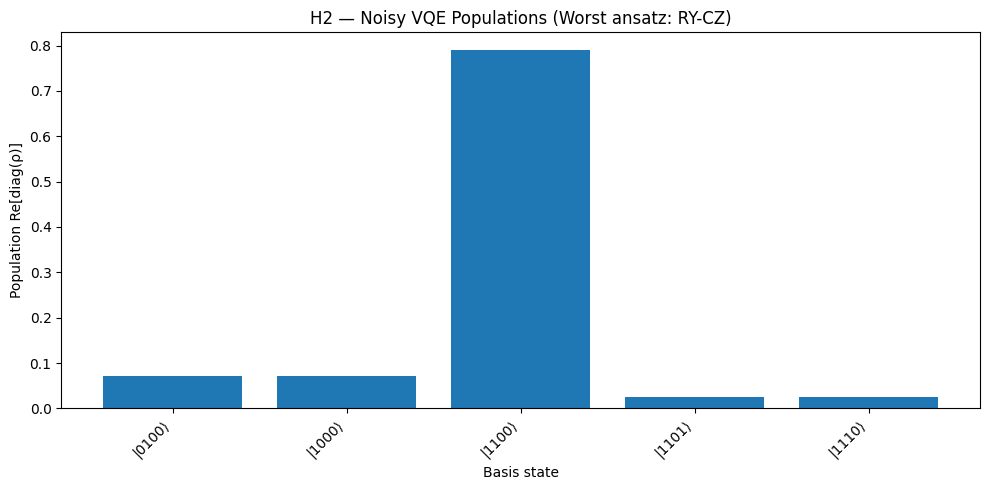

In [19]:
labels = [f"|{i:0{num_wires}b}⟩" for i in idx]
vals = diag[idx]

plt.figure(figsize=(10, 5))
plt.bar(labels, vals)
plt.xlabel("Basis state")
plt.ylabel("Population Re[diag(ρ)]")
plt.title(f"{molecule} — Noisy VQE Populations (Worst ansatz: {worst_ansatz})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()